In [2]:
import re
import shutil
import pickle
import networkx as nx
from pathlib import Path
from glob import glob

from matplotlib import pyplot as plt
mlp_params = {
    "figure.figsize": [9, 6],
    "axes.labelsize": 22,
    "axes.titlesize": 24,
    "axes.titlepad": 15,
    "figure.titlesize": 24,
    "axes.labelpad": 10,
    "font.size": 16,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "text.usetex": True if shutil.which("latex") else False,
    "font.family": "serif",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.top": True,
    "ytick.left": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 2.5,
    "xtick.major.size": 5,
    "ytick.minor.size": 2.5,
    "ytick.major.size": 5,
    "axes.axisbelow": True,
    "figure.dpi": 200,
}
plt.rcParams.update(mlp_params)

# Task 1: Build a citation graph

In [11]:
def extract_titles_and_paths(root):
    papers = {}
    folders = []
    for folder in Path(root).iterdir():
        if folder.is_dir():
            folders.append(folder)
            title_file = folder / "title.txt"
            if title_file.exists():
                with open(title_file, "r", encoding="utf-8") as f:
                    title = f.read().strip().lower()
                    title = re.sub(r"[^a-zA-Z0-9]", "", title)
                    title = re.sub(r"\s+", " ", title).strip()
                papers[title] = {
                    "path": folder,
                    "citations": [],
                }
    return papers, folders

def extract_citations_from_bbl(bbl_path):
    with open(bbl_path, "r", encoding="utf-8") as f:
        content = f.read()
    titles = re.findall(
        r"\\bibitem\{[^}]*\}.*?\\newblock\s+(.*?)[.,]", content, re.DOTALL
    )

    titles = [re.sub(r"[^a-zA-Z0-9]", "", title).strip().lower() for title in titles]
    titles = [re.sub(r"\s+", " ", title).strip() for title in titles]
    return titles

def extract_citations_from_bib(bib_path):
    with open(bib_path, "r", encoding="utf-8") as f:
        content = f.read()
    titles = re.findall(
        r"title\s*=\s*{(.*?)}", content, re.DOTALL
    )
    titles = [re.sub(r"[^a-zA-Z0-9]", "", title).strip().lower() for title in titles]
    titles = [re.sub(r"\s+", " ", title) for title in titles]
    return titles

def build_citation_graph(papers):
    G = nx.DiGraph()
    for title in papers:
        G.add_node(title)
        citations = papers[title]["citations"]
        for cited_title in citations:
            if cited_title in list(papers.keys()):
                G.add_edge(title, cited_title)
    return G

In [4]:
papers, folders = extract_titles_and_paths("dataset_papers")
for i, paper in enumerate(papers):
    bbl_paths = glob(str(papers[paper]["path"] / "*.bbl"))
    bib_paths = glob(str(papers[paper]["path"] / "*.bib"))
    for bbl_path in bbl_paths:
        papers[paper]["citations"].extend(extract_citations_from_bbl(str(bbl_path)))
    for bib_path in bib_paths:
        papers[paper]["citations"].extend(extract_citations_from_bib(str(bib_path)))

In [13]:
G = build_citation_graph(papers)

### 1. The number of edges in the graph.

In [14]:
num_edges = G.number_of_edges()
print(f"Number of edges in the citation graph: {num_edges}")

Number of edges in the citation graph: 25460


### 2. Number of isolated nodes in the graph.

In [15]:
isolated_nodes = [node for node, degree in G.degree() if degree == 0]
num_isolated_nodes = len(isolated_nodes)
print(f"Number of isolated nodes: {num_isolated_nodes}")

Number of isolated nodes: 968


### 3. The average degree (in-degree, out-degree). Plot a histogram of the degrees of nodes.

In [16]:
in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
out_degree = sum(dict(G.out_degree()).values()) / G.number_of_nodes()
print(f"Average in-degree: {in_degree:.2f}")
print(f"Average out-degree: {out_degree:.2f}")

Average in-degree: 3.89
Average out-degree: 3.89


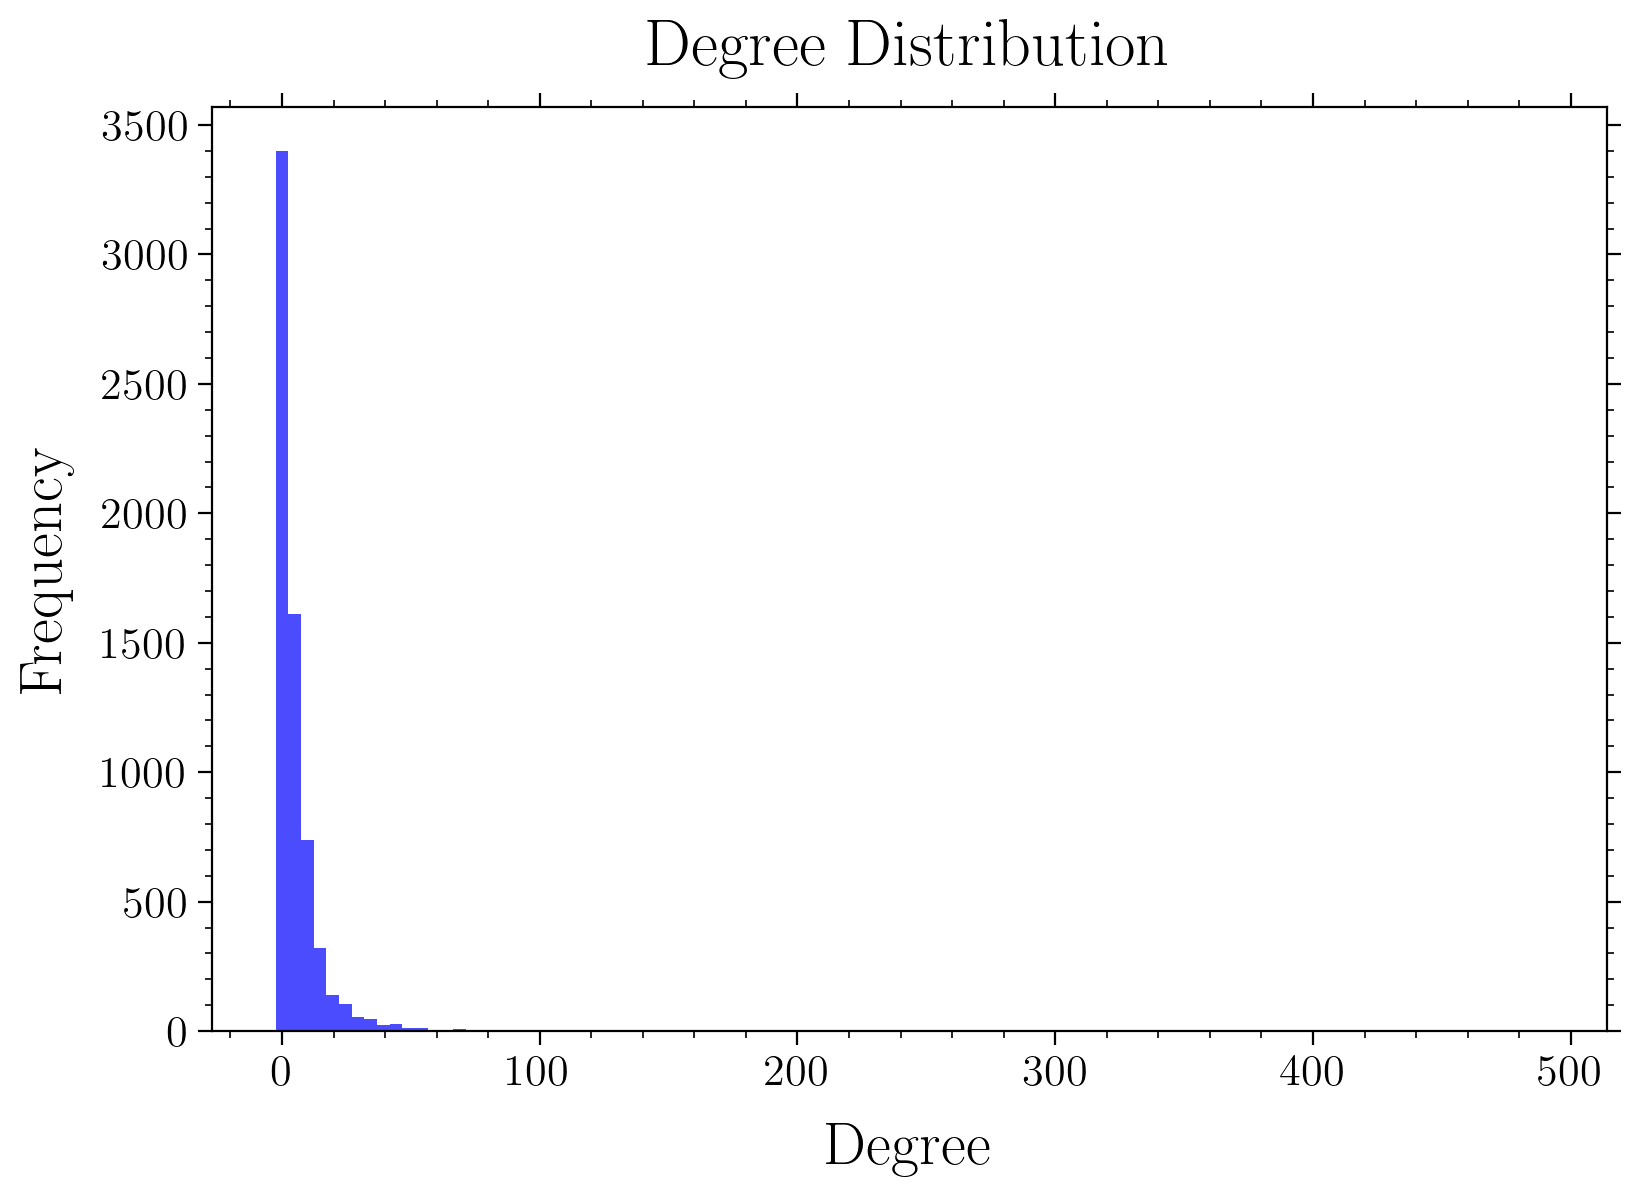

In [17]:
degrees = [d for _, d in G.degree()]
fig, ax = plt.subplots(1, 1)
ax.hist(degrees, bins=100, align='left', color='blue', alpha=0.7)
ax.set_title("Degree Distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
plt.show()

### 4. Diameter of the graph.

### Save the graph to disk

In [101]:
pickle.dump(G, open('graph.pickle', 'wb'))